In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import chirp, correlate
from scipy.ndimage import shift

In [222]:
# Load the data from the "burst" files
files = ["måling1_sweep.csv", "måling2_sweep.csv", "måling3_sweep.csv"]
files = ["real_data/" + file for file in files]
data = [pd.read_csv(f, comment="#") for f in files]
fs = 3.84615e6  # 3.84615 MHz

In [223]:
# Work only with first "måling"
data = data[0]
print(data)

       Time (s)  Channel 1 (V)  Channel 2 (V)
0     -0.000200       0.001586       0.001691
1     -0.000200       0.001979       0.002085
2     -0.000200       0.000484       0.001140
3     -0.000200      -0.000618       0.001140
4     -0.000199       0.002373       0.001928
...         ...            ...            ...
16379  0.004058       0.003082       0.001376
16380  0.004058       0.002294       0.001691
16381  0.004059       0.002531       0.001376
16382  0.004059       0.001901       0.001140
16383  0.004059       0.000326       0.000510

[16384 rows x 3 columns]


In [224]:
time = data.iloc[:, 0].values
channel1 = data.iloc[:, 1].values
channel2 = data.iloc[:, 2].values
print(time, len(time))
print(channel1, len(channel1))
print(channel2, len(channel2))

[-0.00020038 -0.00020012 -0.00019986 ...  0.00405868  0.00405894
  0.0040592 ] 16384
[0.00158591 0.0019795  0.00048385 ... 0.00253052 0.00190078 0.00032641] 16384
[0.00169148 0.00208525 0.00114021 ... 0.00137647 0.00114021 0.00051018] 16384


[ 4.87830372e-05  1.22890858e-07 -5.00731996e-05 ...  1.32920147e-05
  1.25788895e-05  1.17257583e-05]
[-1.54571412e-05 -2.31629861e-05 -3.09665982e-05 ...  8.51009778e-06
  7.91483608e-06  7.26138222e-06]


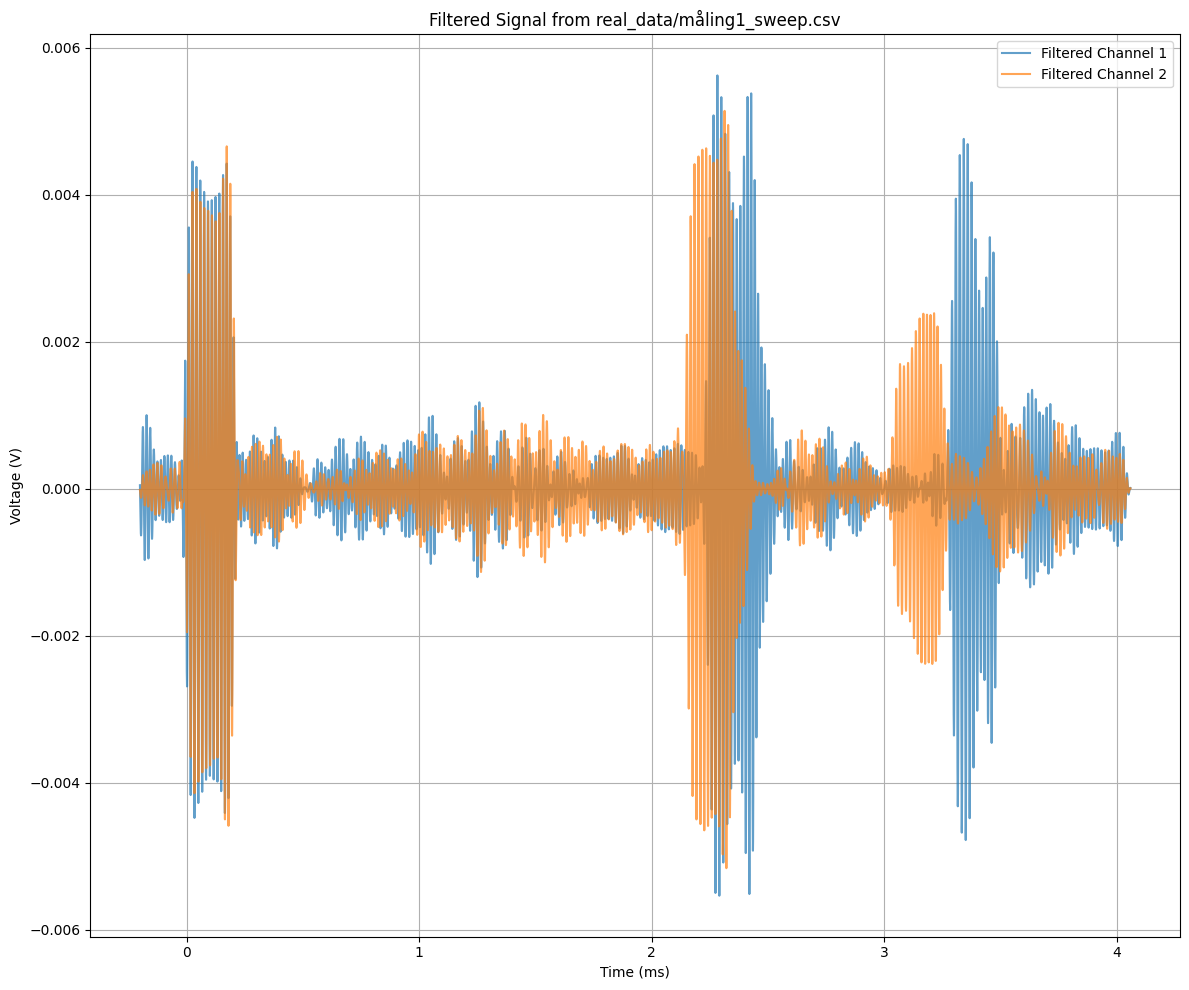

In [225]:
# Run some basic filtering on the signal
# We know that the frequency range we are operating on is from 57kHz to 72kHz ish, so lets just go 50 to 80 kHz
# passband
def bandpass_filter(data, fs, lowpass=50e3, highpass=80e3, order=4):
    nyquist = 0.5*fs
    low = lowpass / nyquist
    high = highpass / nyquist
    b, a = butter(order, [low, high], btype='band') 
    return filtfilt(b, a, data)

channel1 = bandpass_filter(channel1, fs)
channel2 = bandpass_filter(channel2, fs)
print(channel1)
print(channel2)

# Plot the filtered signals
plt.figure(figsize=(12, 10))
plt.plot(time * 1e3, channel1, label=f"Filtered Channel 1", alpha=0.7)
plt.plot(time * 1e3, channel2, label=f"Filtered Channel 2", alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title(f"Filtered Signal from {files[0]}")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

1694
1694 16384
16384 16384


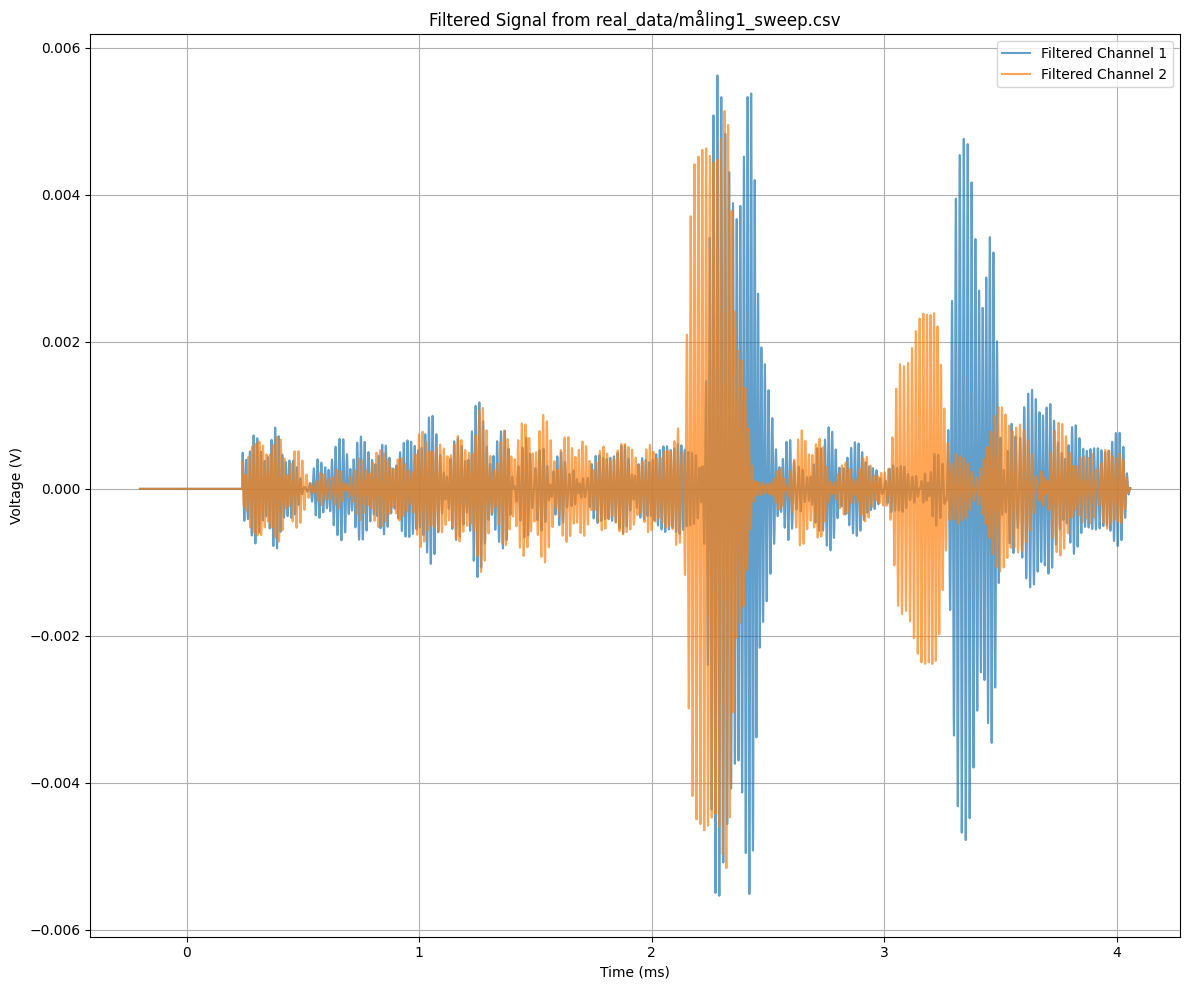

In [226]:
# First 200us of measured data has some emf bleedover from signal generation to transducer
# So just set the channel 1 and 2 values to zero
# t does not start at 0, so must figure out at what index t > 200us
cut_time_index = np.where(time > 200e-6 * 1.2)[0][0] # +20% for good measure
print(cut_time_index)
print(cut_time_index, len(channel1))

channel1_trim = np.concatenate([np.zeros(cut_time_index), channel1[cut_time_index:]])
channel2_trim = np.concatenate([np.zeros(cut_time_index), channel2[cut_time_index:]])
print(len(time), len(channel1_trim))

# Plot the trimmed signals
plt.figure(figsize=(12, 10))
plt.plot(time * 1e3, channel1_trim, label=f"Filtered Channel 1", alpha=0.7)
plt.plot(time * 1e3, channel2_trim, label=f"Filtered Channel 2", alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title(f"Filtered Signal from {files[0]}")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Estimated TDOA (H2 vs H1): 99.06 µs


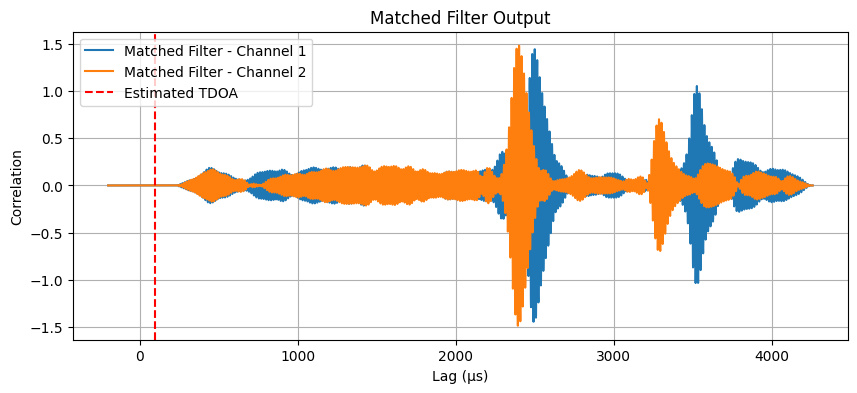

In [227]:
# Trying out match filtering
T = 200e-6  # Duration of sweep
f0, f1 = 58e3, 72e3
ref_time = np.linspace(0, T, int(fs * T))
reference_chirp = chirp(ref_time, f0=f0, f1=f1, t1=T, method='linear')

# Example for burst 0
matched1 = correlate(channel1_trim, reference_chirp, mode='full')
matched2 = correlate(channel2_trim, reference_chirp, mode='full')

lags = np.arange(-len(reference_chirp) + 1, len(channel1_trim))

# Find peak positions
peak1 = np.argmax(np.abs(matched1))
peak2 = np.argmax(np.abs(matched2))

# TDOA in samples and seconds
delta_samples = peak1 - peak2
delta_time = delta_samples / fs
print(f"Estimated TDOA (H2 vs H1): {delta_time * 1e6:.2f} µs")

plt.figure(figsize=(10, 4))
plt.plot(lags / fs * 1e6, matched1, label="Matched Filter - Channel 1")
plt.plot(lags / fs * 1e6, matched2, label="Matched Filter - Channel 2")
plt.axvline((delta_samples / fs) * 1e6, color='r', linestyle='--', label='Estimated TDOA')
plt.xlabel("Lag (µs)")
plt.ylabel("Correlation")
plt.legend()
plt.title("Matched Filter Output")
plt.grid()
plt.show()

In [234]:
d = 0.44  # distance between hydrophones in meters
c = 1440  # speed of sound in water (m/s)

# Clamp sin(theta) to avoid invalid values due to noise
sin_theta = np.clip((delta_time-12e-6) * c / d, -1.0, 1.0)
aoa = np.arcsin(sin_theta) * 180 / np.pi
print(f"Estimated AoA: {aoa:.2f} degrees")

Estimated AoA: 16.55 degrees


In [231]:
# Estimate distance traveled
time_trav_channel2 = time[peak2] - 250e-6 # account for peak being in middle of sweep
distance_peak2 = time_trav_channel2 * c
print(f"Time traveled: {time_trav_channel2*1000:.4f} ms. Distance traveled: {distance_peak2:.2f} m")

Time traveled: 2.1429 ms. Distance traveled: 3.09 m
